<a href="https://colab.research.google.com/github/DIFACQUIM/Cursos/blob/main/7_1_Representaci%C3%B3n_molecular__Similitud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Huellas digitales moleculares (molecular fingerprints)**


---



---



Última actualización: 28-02-2025.

---



---






# ***Tabla de Contenido***
- [0 - ***Librerias: cargado e instalación***](#0)
- [1 - ***Introducción***](#1)
- [2 - ***Representaciones***](#2)
  - [2.1 - ***Grafos***](#2.1)
    - [2.1.1 - ***2D***](#2.1.1)
    - [2.1.2 - ***3D***](#2.1.2)
  - [2.2 - ***Huellas moleculares***](#2.2)
    - [2.2.1 - ***Basadas en subestructuras o diccionarios***](#2.2.1)
        - [A - ***MACCS (Molecular ACCess System) Keys***](#2.2.1A)
        - [A.1 - ***Visualización gráfica de la huella molecular***](#2.2.1A1)
        - [B - ***PubChem***](#2.2.1B)
    - [2.2.2 - ***Topológicas o basadas en rutas***](#2.2.2)
        - [***Huellas moleculares circulares***](#2.2.2.1)
        - [A - ***Conectividad extendida (ECFP)***](#2.2.2A)
        - [B - ***De clase funcional (FCFP)***](#2.2.2B)
- [3 - ***Ejercicio***](#3)
- [4 - ***Referencias y fuentes de consulta***](#4)

---



---




<a name='0'></a>

# **Librerias: cargado e instalación**

In [ ]:
import time
from IPython.utils import io
import tqdm.notebook
import os, sys, random
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
        pbar.update(30)
        !pip install rdkit
        !pip install PubChemPy
        !pip install kora py3Dmol
        import kora.install.rdkit
        import py3Dmol

        pbar.update(30)
        import pandas as pd
        from rdkit import Chem, DataStructs, RDConfig
        from rdkit.Chem import MACCSkeys, AllChem, RDKFingerprint, Draw, Descriptors, PandasTools, Pharm2D
        from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
        import pubchempy as pcp
        import matplotlib.pyplot as plt
        import numpy as np
        pbar.update(40)

  0%|          | 0/100 [00:00<?, ?it/s]

<a name='1'></a>

# **1 - Introducción**
Las huellas digitales moleculares (*molecular fingerprints*) son un tipo de descriptor molecular que codifica la estructura de una molécula en una secuencia de *bits* de manera que se pueda comparar y analizar computacionalmente.

La mayoría de los métodos usan solamente grafos moleculares en 2D y son llamados huellas digitales 2D; sin embargo, algunos métodos son capaces de almacenar información en 3D, más notablemente las huellas moleculares farmacofóricas.
Existen varios tipos de huellas digitales, incluyendo huellas digitales basadas en subestructuras, como las "claves MACCS" (key MACCS), y huellas digitales topológicas, que codifican la topología general o la conectividad de la molécula sin codificar explícitamente subestructuras específicas.

En aspectos generales, las huellas digitales **basadas en subestructuras** se crean codificando la presencia o ausencia de subestructuras específicas en la molécula, mientras que las huellas digitales **topológicas** codifican la conectividad o forma general de la molécula. Las huellas digitales topológicas se pueden subdividir en huellas digitales basadas en rutas, que codifican la presencia o ausencia de rutas particulares en la representación gráfica de la molécula, y huellas digitales circulares, que codifican la presencia o ausencia de subestructuras circulares o patrones particulares.

Las huellas digitales se utilizan típicamente para calcular la similitud entre dos moléculas, lo que se puede utilizar para identificar moléculas que son estructuralmente similares y que pueden tener una actividad biológica similar, lo que las convierte en posibles candidatos a fármacos. Las puntuaciones de similitud se calculan típicamente comparando las huellas digitales de dos moléculas y calculando una puntuación de similitud.

El uso de huellas digitales moleculares en quimioinformática tiene muchas ventajas, incluyendo la capacidad de representar estructuras moleculares complejas de manera eficiente computacionalmente y la capacidad de comparar grandes bases de datos de moléculas de manera rápida y precisa. Sin embargo, también hay limitaciones en el uso de huellas digitales, como la incapacidad de capturar todos los aspectos de la similitud molecular y el potencial de falsos positivos o falsos negativos en los cálculos de similitud.

En general, las huellas digitales moleculares son una herramienta poderosa en quimioinformática que se utilizan ampliamente en el descubrimiento de fármacos, ciencias de materiales y otras áreas de investigación. La elección del tipo de huella digital dependerá de la aplicación específica y las propiedades de las moléculas que se estén analizando.

Nota: La generación de los diversos fingerprints de este script consideran el SMILES de la aspirina como input para fines prácticos.

<a name='2'></a>

# **2 - Representaciones:**

<a name='2.1'></a>
## 2.1 - Grafos

<a name='2.1.1'></a>
### **2.1.1 - 2D**

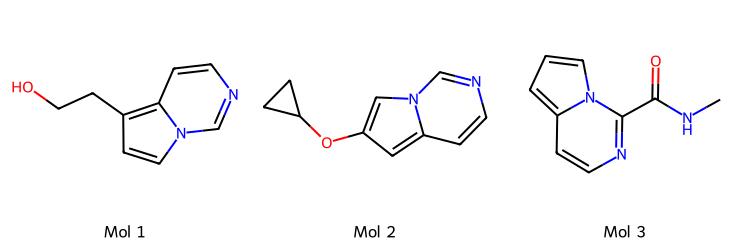

In [ ]:
list_of_smiles = ['OCCc1ccn2cnccc12','C1CC1Oc1cc2ccncn2c1','CNC(=O)c1nccc2cccn12']
mol_list = [Chem.MolFromSmiles(smi) for smi in list_of_smiles]
for mol in mol_list:
  tmp=AllChem.Compute2DCoords(mol)


# Asignar nombres a las moléculas (opcional si no están definidos)
for idx, mol in enumerate(mol_list):
    if mol is not None:  # Evitar errores si hay SMILES inválidos
        mol.SetProp("_Name", f"Mol {idx+1}")

"""
img = Draw.MolToImage(mol_list[1], size=(300, 300))
img.show()
"""

img_grid = Draw.MolsToGridImage(
    mol_list,
    molsPerRow=3,
    subImgSize=(250, 250),
    legends=[mol.GetProp("_Name") if mol is not None else "Unknown" for mol in mol_list]
)

#img_grid.save("mol_grid.png")  # Guardar la imagen en un archivo
img_grid

### **2.1.2 - 3D**

In [ ]:
def show_3d_figure(smi, style='stick'): #'sphere'
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mol = Chem.RemoveHs(mol)
    mblock = Chem.MolToMolBlock(mol)

    view = py3Dmol.view(width=200, height=200)
    view.addModel(mblock, 'mol')
    view.setStyle({style:{}})
    view.zoomTo()
    view.show()

In [ ]:
# example
for i in list_of_smiles:
  show_3d_figure(i)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<a name='2.2'></a>

## **2.2- Huellas moleculares**

<a name='2.2.1'></a>

#### **2.2.1- Basadas en subestructuras o diccionarios**


Las firmas basadas en subestructuras se generan mediante la codificación de la presencia o ausencia de una carácteristica o subestructuras específicas en una molécula de una lista dada de claves estructurales. Esto implica definir un conjunto de subestructuras o fragmentos moleculares que se consideran importantes o relevantes para una aplicación específica y, luego, generar una firma binaria que codifique si cada una de estas subestructuras está presente o ausente en la molécula. Algunas de las huellas basadas en subestructuras más comunes son:

<a name='2.2.1A'></a>

##### **A - MACCS (Molecular ACCess System) Keys**
 Viene en dos variantes de fierente longitud de bits, una con **960** y otra con **166** claves estructurales basadas en patrones SMARTS. La más corta es la más comúnmente usada debido a su longitud relativamente corta pero cubre la mayor parte de las características químicas de interés para el descubrimiento de fármacos y cribado virtual. Además, diversos softwares son capaces de calcularlos, lo cual no es cierto para la versión larga.
A continuación, un ejemplo de código en el cual se establece el uso de MACCS keys

In [ ]:
def get_similarity_matrix(fingerprints, similarity_metric=DataStructs.TanimotoSimilarity):
    """
    Calcula la matriz de similitud entre huellas moleculares (fingerprints).

    Parámetros:
    - fingerprints: Lista de huellas moleculares generadas con RDKit.
    - similarity_metric: Función de similitud a utilizar (Tanimoto, Dice, etc.).

    Retorna:
    - matriz: DataFrame de Pandas con los valores de similitud.
    """

    # Crear una matriz vacía
    n = len(fingerprints)
    matrix = pd.DataFrame(index=range(1, n + 1), columns=range(1, n + 1), dtype=float)

    # Calcular la similitud y llenar la matriz
    for i in range(n):
        for j in range(i, n):  # Solo llenar la mitad superior para evitar cálculos redundantes
            sim_value = round(similarity_metric(fingerprints[i], fingerprints[j]), 3)
            matrix.iloc[i, j] = sim_value
            matrix.iloc[j, i] = sim_value  # La matriz es simétrica

    return matrix

# Ejemplo de uso
# fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in mol_list]
# sim_matrix = get_similarity_matrix(fps)
# print(sim_matrix)


In [ ]:
# Generar las MACCS Keys para cada molécula
fps = [MACCSkeys.GenMACCSKeys(x) for x in mol_list]
# Convertir las MACCS Keys en una representación legible
for i, fp in enumerate(fps):
    fps_bits=list(fp.GetOnBits())
    print(f"Molécula {i+1}:")
    print(f"MACCS Key: {fp.ToBitString()}")
    print(f"Lista de bits activos: {fps_bits}")
get_similarity_matrix(fps)

Molécula 1:
MACCS Key: 00000000000000000000000000000000000000000000000000000000000000000100000000000100101101000000000010100100110001000000001011100100000010000101001000011000010111000111110
Lista de bits activos: [65, 77, 80, 82, 83, 85, 96, 98, 101, 104, 105, 109, 118, 120, 121, 122, 125, 132, 137, 139, 142, 147, 148, 153, 155, 156, 157, 161, 162, 163, 164, 165]
Molécula 2:
MACCS Key: 00000000000000000000001000000000000000000000000000000000000000000100000000000100100101000000000111100100010000000100000011100111000010000100001100011000100011000111110
Lista de bits activos: [22, 65, 77, 80, 83, 85, 95, 96, 97, 98, 101, 105, 113, 120, 121, 122, 125, 126, 127, 132, 137, 142, 143, 147, 148, 152, 156, 157, 161, 162, 163, 164, 165]
Molécula 3:
MACCS Key: 00000000000000000000000000000000000000100000000000000000000000000100000000000101100101000000110110100100010000100000010011100100000000000100001000001001001010101111110
Lista de bits activos: [38, 65, 77, 79, 80, 83, 85, 92, 93, 95, 96, 98, 

,1,2,3
1,1.000,0.625,0.512
2,0.625,1.000,0.535
3,0.512,0.535,1.000


<a name='2.2.1A1'></a>

##### A.1 - Visualización gráfica de la huella mecular
###### Gráfico de barras o histograma

In [ ]:
def visualización_fps_completa(fps):
  bit_counts = [fps.GetBit(id) for id in range(fps.GetNumBits())]   # Contar la frecuencia de cada bit activo
  # Crear un histograma
  plt.figure(figsize=(9,4))
  plt.bar(range(len(bit_counts)), bit_counts)
  plt.xlabel("Índice del bit")
  plt.ylabel("Frecuencia")
  plt.title("Histograma de la Huella molecular")
  plt.tight_layout()
  plt.show()

In [ ]:
def visualización_fps_activos(fps, mol_images):
    for fp, i in enumerate(fps):
        bit_counts = [i.GetBit(id) for id in range(i.GetNumBits())]     # Contar la frecuencia de cada bit activo
        active_indices = [i for i, bit in enumerate(bit_counts) if bit != 0]  # Obtener los índices de los bits activos

        x_labels = [str(i) for i in active_indices]  # Crear una lista de etiquetas para el eje x con los índices activos

        # Crear un subplot con dos filas y una columna
        fig, ax = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

        # Plotear el histograma en el primer subplot
        ax[0].bar(active_indices, [bit_counts[i] for i in active_indices])
        ax[0].set_xlabel("Índice del bit")
        ax[0].set_ylabel("Frecuencia")
        ax[0].set_title(f"Histograma de la Huella molecular de la Molécula {fp+1}:")
        ax[0].set_yticks(np.arange(0, max(bit_counts) + 1, step=1.0))
        ax[0].set_xticks(active_indices)
        ax[0].set_xticklabels(x_labels, rotation=90)

        # Plotear la imagen de la molécula en el segundo subplot
        ax[1].imshow(mol_images[fp])
        ax[1].axis('off')  # Desactivar los ejes para la imagen

        plt.tight_layout()
        plt.show()

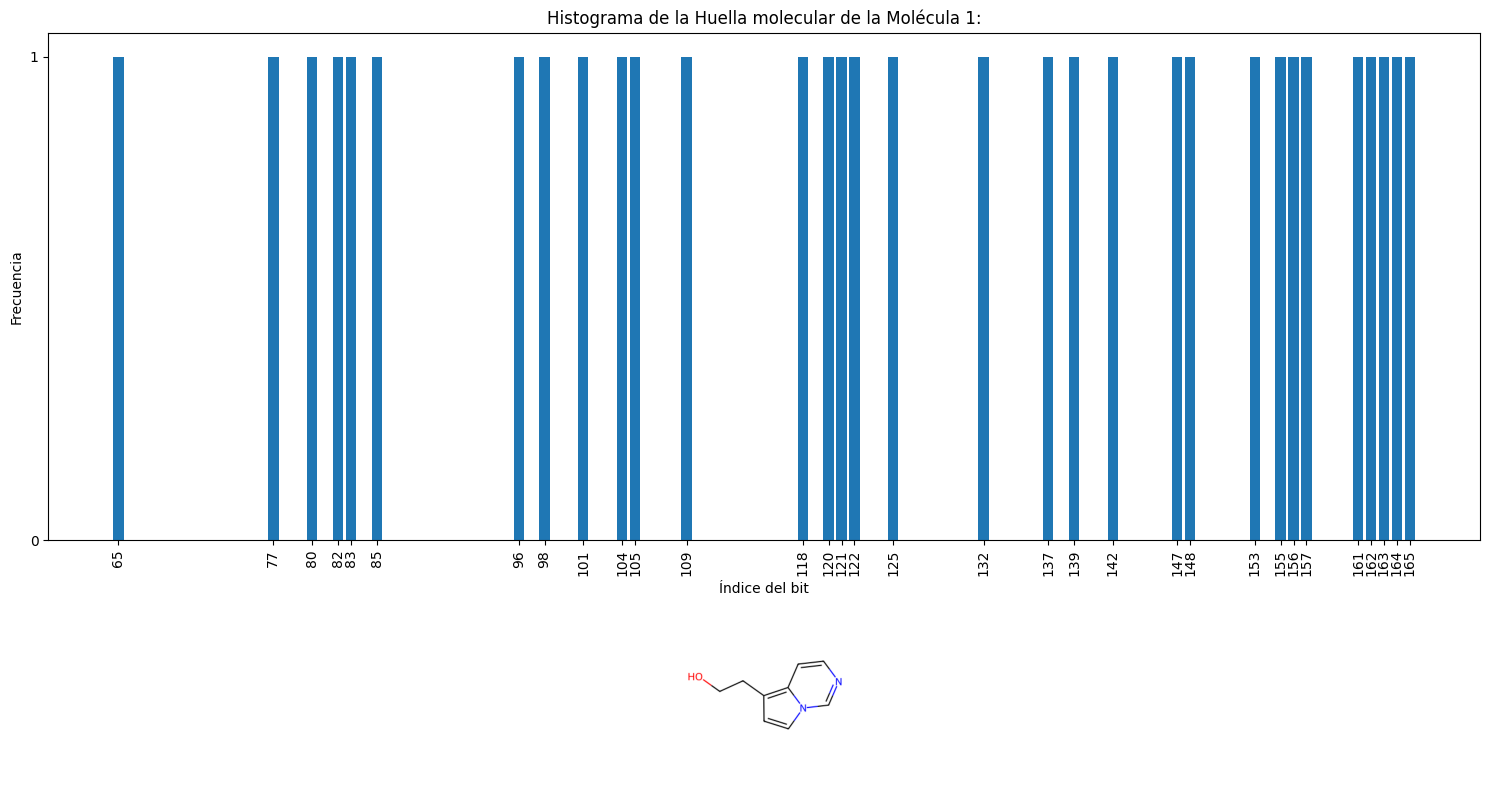

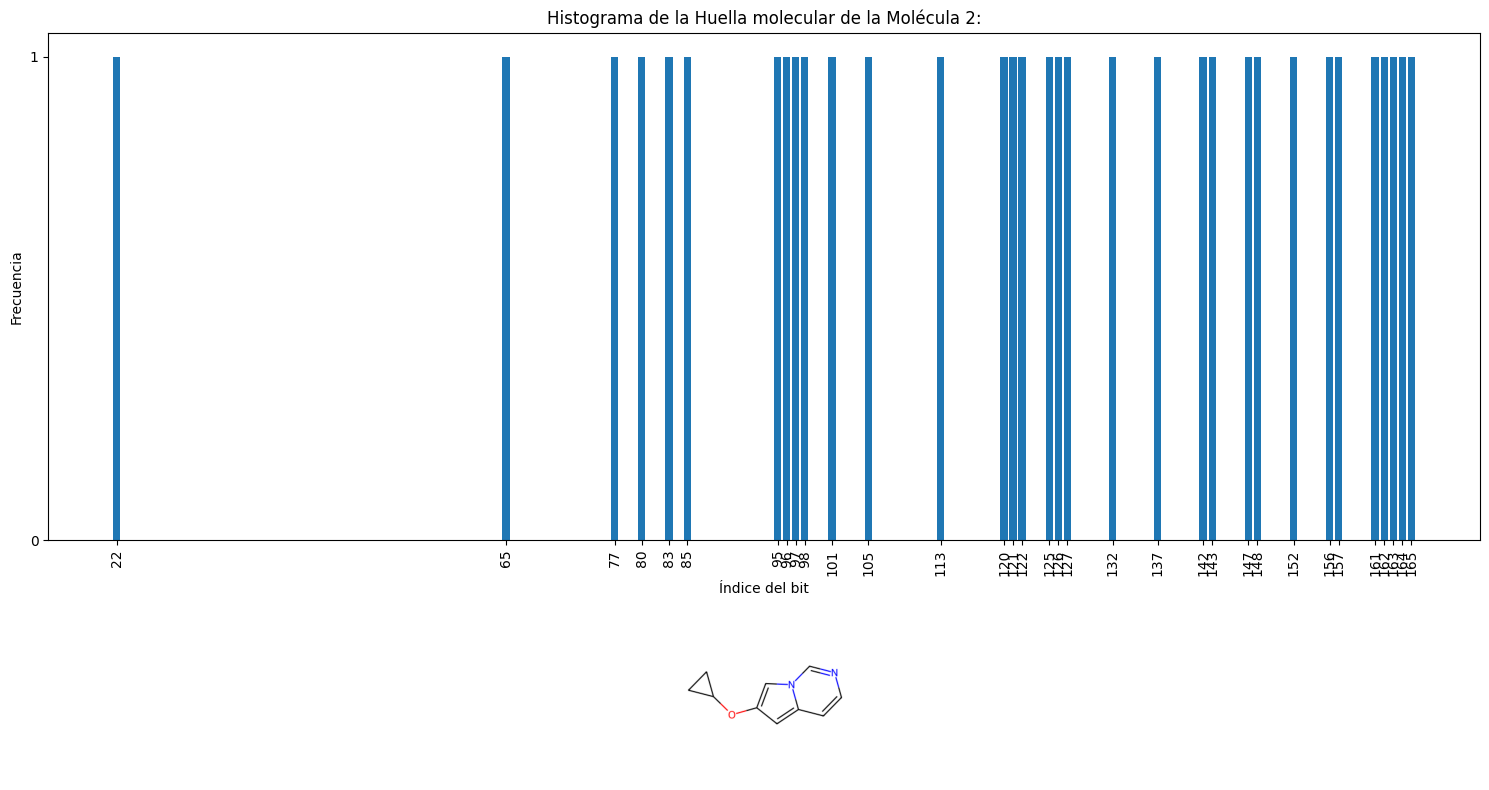

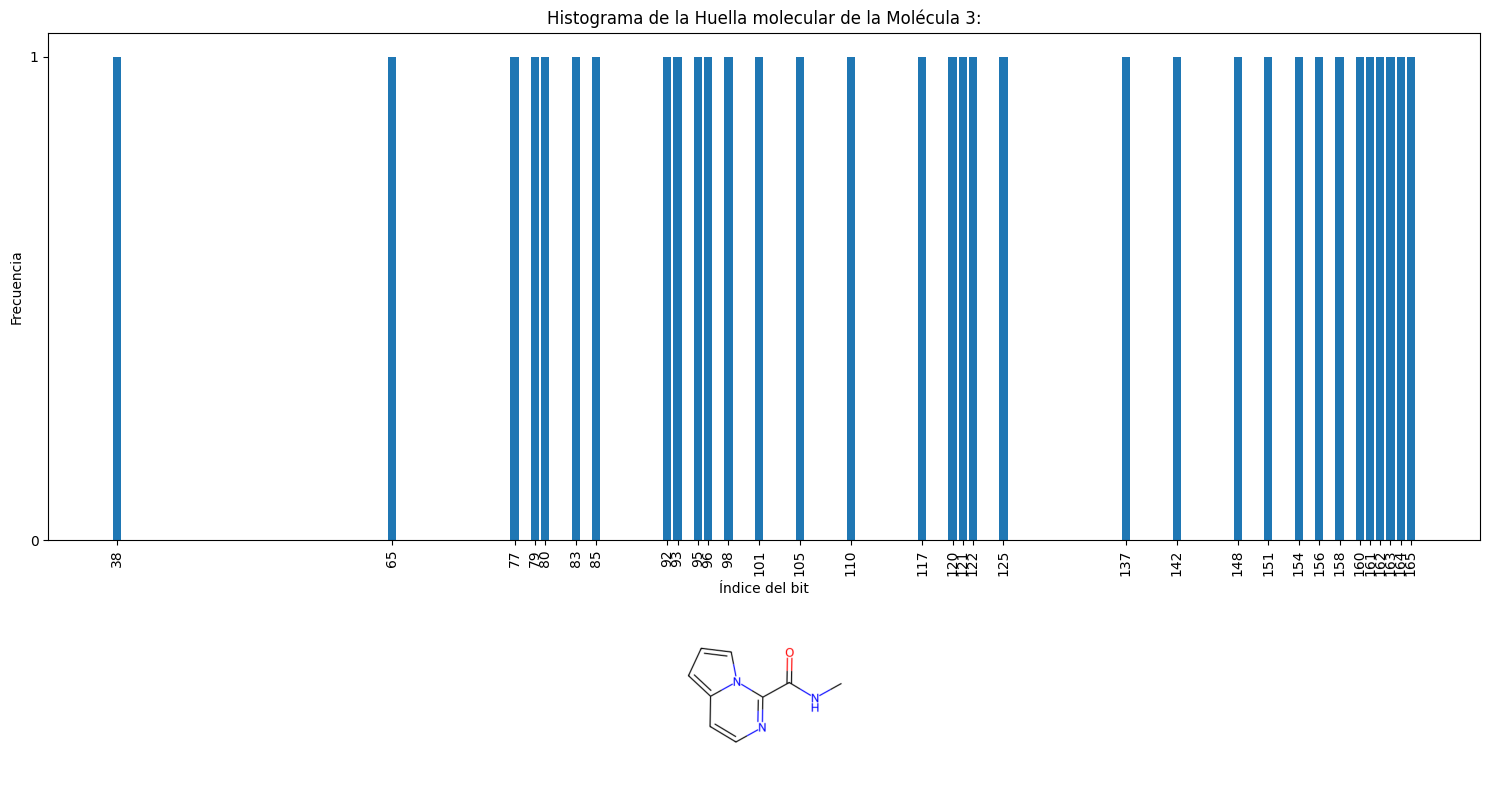

In [ ]:
mol_images = [Draw.MolToImage(mol, size=(300, 300)) for mol in mol_list]

visualización_fps_activos(fps=fps,mol_images=mol_images)

<a name='2.2.1B'></a>

##### **B - PubChem**
Cuenta con **881** claves estructurales. Son empleados por PubChem para la búsqueda por similitud y por vecinos. Está implementado en ChemFP y en CDK.
A continuación, un ejemplo de código en el cual se establece el uso de las huellas moleculares de PubChem.

In [ ]:
# Nombre o identificador del compuesto que deseas buscar
compound_name = "aspirin"

# Realiza la búsqueda en PubChem
compounds = pcp.get_compounds(compound_name, 'name')
if compounds:
    # Obtiene el primer resultado (puede haber múltiples resultados)
    compound = compounds[0]
    # Obtiene la huella molecular de PubChem
    fingerprint = compound.fingerprint
    posiciones_no_cero = {}
    # Enumerar el string y agregar las posiciones a un diccionario
    for i, valor in enumerate(fingerprint):
        if valor != '0':
            posiciones_no_cero[i] = valor

    print(f"Nombre del compuesto: {compound.synonyms[0]}")
    print(f"Lista de bits activos (posición:valor)= {posiciones_no_cero}")
    print(f"Huella molecular PubChem: {fingerprint}")

else:
    print(f"No se encontraron resultados para '{compound_name}'.")

Nombre del compuesto: aspirin
Lista de bits activos (posición:valor)= {5: '3', 6: '7', 7: '1', 8: 'C', 10: '7', 12: '3', 13: '8', 52: '3', 71: '1', 78: '1', 79: 'A', 85: '8', 91: 'C', 93: '4', 94: '8', 96: '9', 97: '8', 100: '3', 101: '2', 103: 'E', 104: '8', 109: '6', 112: '8', 113: '8', 115: '2', 116: '2', 118: 'D', 119: '2', 121: '8', 125: '2', 127: '8', 130: '2', 131: '4', 132: '2', 137: '8', 138: '8', 139: '8', 141: '1', 143: '6', 145: '8', 146: 'C', 147: '8', 149: 'C', 150: '2', 151: '7', 152: '3', 153: '6', 154: '8', 155: '4', 156: '3', 157: '5', 158: '1', 159: 'A', 160: '8', 161: '2', 162: '7', 163: 'B', 164: '6', 166: 'A', 167: '5', 168: 'E', 170: '1', 171: '1', 173: '8', 174: 'B', 175: '9', 176: '8', 177: '7', 178: '8', 179: '8', 180: 'C', 181: '8', 182: '2', 184: '8', 185: 'E', 197: '8', 212: '1'}
Huella molecular PubChem: 00000371C0703800000000000000000000000000000000000000300000000000000000010000001A00000800000C04809800320E80000600880220D208000208002420000888010608C80C2736

<a name='2.2.2'></a>

### **2.2.2 - Topológicas o basadas en rutas**
Las firmas topológicas se generan mediante la codificación de la conectividad o forma general de una molécula, sin codificar explícitamente subestructuras específicas. Trabajan al analizar todos los fragmentos de la molécula siguiendo un camino (usualmente lineal) hasta un cierto número de enlaces, y después combinar cada una de estas rutas (secuencias de átomos o enlaces) para crear la huella molecular. Lo anterior significa que cualquier molécula puede producir una huella molecular significativa y su longitud puede ser ajustada. Son usados comúnmente para una veloz búsqueda y filtrado por subestructuras. Se debe tomar en cuenta que un solo bit no se puede rastrear hasta una característica determinada y un bit determinado puede estar configurado por más de una característica diferente (colisión de bits). La mayoría de los softwares implementan estas huellas moleculares o basadas en ellas. Daylight es el ejemplo más común de este tipo de huellas moleculares.
A continuación, un ejemplo de código en el cual se establece el uso de las huellas moleculares topológicas.

In [ ]:
# Crear una molécula a partir de un SMILES
smiles = list_of_smiles[0]
mol_list = [Chem.MolFromSmiles(s) for s in ['CCOC', 'CCO', smiles]]
fpgen = AllChem.GetRDKitFPGenerator() #Inicializamos un generador de fps
fingerprints = [fpgen.GetFingerprint(mol) for mol in mol_list]
# Imprimir información de cada huella molecular
for idx, fp in enumerate(fingerprints, start=1):
    print(f"Molécula {idx}:")
    print(f"Huella molecular: {fp.ToBitString()}")
    print(f"Lista de bits activos: {list(fp.GetOnBits())}\n")
get_similarity_matrix(fingerprints)

Molécula 1:
Huella molecular: 0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

,1,2,3
1,1.000,0.600,0.013
2,0.600,1.000,0.013
3,0.013,0.013,1.000


<a name='2.2.2.1'></a>

#### **Huellas moleculares circulares**
Las firmas circulares también pertenecen al tipo topológico, sin embargo son un tanto diferentes ya que estas no se centran en la búsqueda de rutas, sino en el ambiente de cada átomo hasta un determinado radio. No son adecuados para búsquedas por subestructura pero si para búsquedas de similitud estructural completa.

<a name='2.2.2A'></a>

#### **A - Conectividad extendida (ECFP, Extended-Connectivity Fingerprints)**
La huella molecular circular basada en el algoritmo de Morgan es la estándar, la cual fue diseñada específicamente para su uso en modelado estructura-actividad. Representan el vecindario atómico circular y produce una huella molecular de longitud variable. Son usadas comúnmente considerando un diámetro de 4 Å (ECFP4) y 6 Å (ECFP6). Notables softwares proporcionan estas huellas moleculares, tales como: Pipeline Pilot, Chemaxon’s JChem, CDK y RDKit.
A continuación, un ejemplo de código en el cual se establece el uso de las huellas moleculares circulares.

In [ ]:
def get_Morgan_fps(smiles_list, radius, nBits):

    # Crear una molécula a partir de un SMILES
    mol_list = [Chem.MolFromSmiles(s) for s in smiles_list]
    fpgen = AllChem.GetMorganGenerator(radius=radius, fpSize = nBits) #Generador con radio X
    fingerprints = [fpgen.GetFingerprint(mol) for mol in mol_list]
    # Imprimir información de cada huella molecular
    for idx, fp in enumerate(fingerprints, start=1):
        print(f" Molécula {idx}:")
        print(f"  Huella molecular: {fp.ToBitString()}")
        print(f"    Lista de bits activos: {list(fp.GetOnBits())}")

    print("Matriz de Similitud:")
    return get_similarity_matrix(fingerprints)

get_Morgan_fps(smiles_list=list_of_smiles, radius=2, nBits=2048) #ECFP4
get_Morgan_fps(smiles_list=list_of_smiles, radius=3, nBits=2048) #ECFP6

 Molécula 1:
  Huella molecular: 0000000000000000000000000000000000000000000001000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000101000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000001000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010010000000000000000000000000000000

,1,2,3
1,1.000,0.203,0.116
2,0.203,1.000,0.123
3,0.116,0.123,1.000


<a name='2.2.2B'></a>

#### **B - De clase funcional (FCFP, Functional-Class Fingerprints)**

Son una variante de los ECFP, solo que más abstractos y que en lugar de indexar un átomo particular en el ambiente, indexan el rol del átomo. Así que diferentes átomos o grupos con la misma o similar función no son distinguibles por la huella molecular. Lo anterior les permite ser usado como huellas moleculares farmacofóricas. La mayoría de los softwares que soportan ECFP también soportan esta variante.

In [ ]:
if mol is not None:
    # Configurar parámetros para la huella digital FCFP
    radius = 2  # Radio ajustable
    use_features = True  # Indexación del rol del átomo
    # Generar la huella digital FCFP
    fcfp_fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, useFeatures=use_features, nBits=2048)
    # Convertir la huella digital en una representación legible
    fcfp_fingerprint_bits = list(fcfp_fingerprint.GetOnBits())

    print(f"Lista de bits activos en FCFP: {fcfp_fingerprint_bits}")
    print(f"Huella molecular FCFP: {fcfp_fingerprint.ToBitString()}")
else:
    print("No se pudo crear una molécula a partir del SMILES proporcionado.")

Lista de bits activos en FCFP: [0, 1, 2, 4, 6, 181, 311, 397, 499, 555, 590, 743, 779, 928, 1155, 1216, 1223, 1379, 1491, 1678, 1863, 1879, 1918, 2017, 2039, 2040]
Huella molecular FCFP: 111010100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000100000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000001000000000000000000000000000000000

[01:09:31] DEPRECATION WARNING: please use MorganGenerator


<a name='3'></a>
# ***3. Ejercicio con base de datos***

In [ ]:
# Leer archivo
url = 'https://github.com/DIFACQUIM/Cursos/raw/main/Datasets/Fingerprints.csv'
df = pd.read_csv(url)
df.head()

,ID,smiles,IC50,std_units,pIC50,%activity(100uM),Activity
0,CHEMBL3087498,Brc1c2c(N)ncnc2n([C@]2[C@](O)[C@](O)[C@@](CN(C...,0.3,nM,9.522879,NaN,Inhibitor
1,CHEMBL2171169,O=C(NCCCN(C(C)C)C[C@@]1[C@@](O)[C@@](O)[C@](n2...,2.9,nM,8.537602,NaN,Inhibitor
2,CHEMBL83747,Brc1c(O)ccc(C/C(=N\O)/C(=O)NCCSSCCNC(=O)/C(=N/...,18.6,nM,7.730487,NaN,Inhibitor
3,CHEMBL4215326,O(C)c1c(OC2CC3(CN(C)C3)C2)cc2nc(-c3oc(C)cc3)cc...,21.0,nM,7.677781,NaN,Inhibitor
4,CHEMBL1201129,O=C1N([C@@]2O[C@](CO)[C@@](O)C2)C=NC(N)=N1,30.0,nM,7.522879,NaN,Inhibitor


,ID,smiles,IC50,std_units,pIC50,%activity(100uM),Activity,ROMol,ROMol_H
0,CHEMBL3087498,Brc1c2c(N)ncnc2n([C@]2[C@](O)[C@](O)[C@@](CN(C...,0.3,nM,9.522879,NaN,Inhibitor,,
1,CHEMBL2171169,O=C(NCCCN(C(C)C)C[C@@]1[C@@](O)[C@@](O)[C@](n2...,2.9,nM,8.537602,NaN,Inhibitor,,
2,CHEMBL83747,Brc1c(O)ccc(C/C(=N\O)/C(=O)NCCSSCCNC(=O)/C(=N/...,18.6,nM,7.730487,NaN,Inhibitor,,
3,CHEMBL4215326,O(C)c1c(OC2CC3(CN(C)C3)C2)cc2nc(-c3oc(C)cc3)cc...,21.0,nM,7.677781,NaN,Inhibitor,,
4,CHEMBL1201129,O=C1N([C@@]2O[C@](CO)[C@@](O)C2)C=NC(N)=N1,30.0,nM,7.522879,NaN,Inhibitor,,
...,...,...,...,...,...,...,...,...,...
194,F447-0397,S(=O)(=O)(Nc1cc2c(C(=O)O)cc(N3CCN(c4ccc(OC)cc4...,57000.0,nM,4.244125,NaN,Inhibitor,,
195,FC.CSC.04E fr 16-20,Clc1cc(NS(=O)(=O)c2ccc(NS(=O)(=O)c3cc4c(cc3)cc...,NaN,NaN,NaN,97.0,Inhibitor,,
196,FC.CSC.10C fr 4,S(=O)(=O)(Nc1cc(OC)cc(OC)c1)c1cc2c(cc1)cccc2,NaN,NaN,NaN,NaN,Inhibitor,,
197,DLP18,O=C(Nc1nocc1)CN1CCN(c2ccc(C(=O)OCC)cc2)CC1,NaN,NaN,NaN,NaN,Inhibitor,,

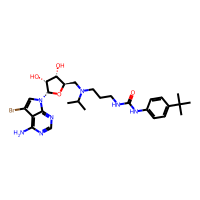
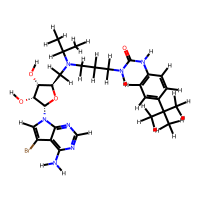
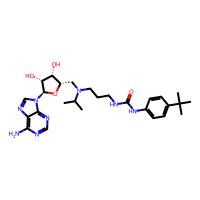
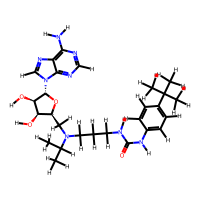
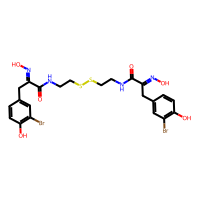
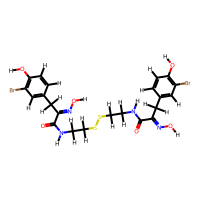
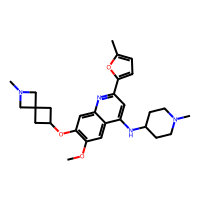
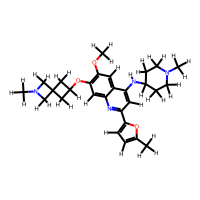
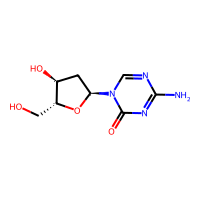
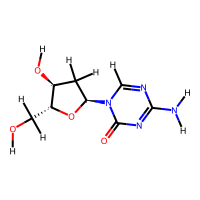
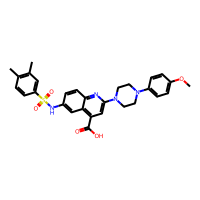
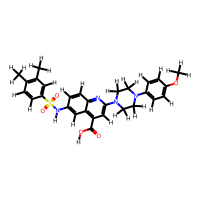
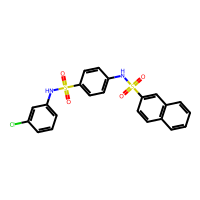
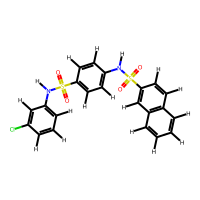
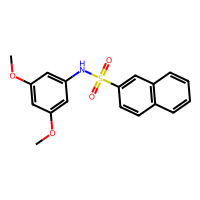
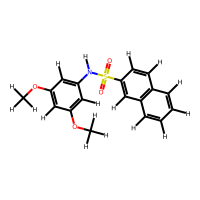
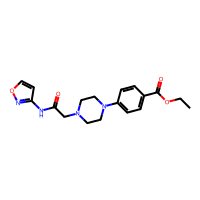
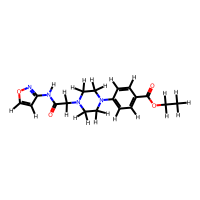
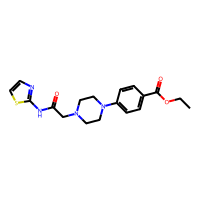
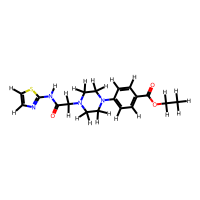

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')
df['ROMol_H'] = [Chem.AddHs(m) for m in df['ROMol']]
df

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Pharm2D
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D

def fingerprint(dataframe, column="ROMol_H"):
    """
    Genera huellas moleculares (ECFP6, MACCS, 2D y 3D farmacofórico) para cada molécula en un DataFrame.

    Parámetros:
    - dataframe (pd.DataFrame): DataFrame con una columna de moléculas RDKit.
    - column (str): Nombre de la columna con las moléculas RDKit.

    Retorna:
    - pd.DataFrame con nuevas columnas de huellas moleculares.
    """
    tic = time.time()
    factory = Gobbi_Pharm2D.factory  # Definición del farmacóforo 2D
    fpgen = AllChem.GetMorganGenerator(radius=3, fpSize=1024)  # Generador de ECFP6

    ecfp6_list, maccs_list, fp2d_list, fp3d_list = [], [], [], []

    for mol in dataframe[column]:
        if mol is None:  # Manejo de moléculas inválidas
            ecfp6_list.append(None)
            maccs_list.append(None)
            fp2d_list.append(None)
            fp3d_list.append(None)
            continue

        # Generar huellas moleculares
        ecfp6_list.append(fpgen.GetFingerprint(mol))
        maccs_list.append(MACCSkeys.GenMACCSKeys(mol))

        # Generar farmacofórico 2D
        fp2d_list.append(Pharm2D.Generate.Gen2DFingerprint(mol, factory))

        # Generar farmacofórico 3D
        AllChem.EmbedMolecule(mol, useRandomCoords=True)  # Evita errores de conformación
        matriz_3d = Chem.Get3DDistanceMatrix(mol)
        fp3d_list.append(Pharm2D.Generate.Gen2DFingerprint(mol, factory, dMat=matriz_3d))

    # Asignar listas al DataFrame
    dataframe["ECFP6"] = ecfp6_list
    dataframe["MACCS"] = maccs_list
    dataframe["Fp2D"] = fp2d_list
    dataframe["Fp3D"] = fp3d_list
    tac = time.time()
    print(f" Amount of time: {round((tac-tic)/60, 2)}")
    return dataframe

152.8107349872589


,ID,smiles,IC50,std_units,pIC50,%activity(100uM),Activity,ROMol,ROMol_H,ECFP6,MACCS,Fp2D,Fp3D
0,CHEMBL3087498,Brc1c2c(N)ncnc2n([C@]2[C@](O)[C@](O)[C@@](CN(C...,0.3,nM,9.522879,NaN,Inhibitor,,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL2171169,O=C(NCCCN(C(C)C)C[C@@]1[C@@](O)[C@@](O)[C@](n2...,2.9,nM,8.537602,NaN,Inhibitor,,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL83747,Brc1c(O)ccc(C/C(=N\O)/C(=O)NCCSSCCNC(=O)/C(=N/...,18.6,nM,7.730487,NaN,Inhibitor,,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL4215326,O(C)c1c(OC2CC3(CN(C)C3)C2)cc2nc(-c3oc(C)cc3)cc...,21.0,nM,7.677781,NaN,Inhibitor,,,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL1201129,O=C1N([C@@]2O[C@](CO)[C@@](O)C2)C=NC(N)=N1,30.0,nM,7.522879,NaN,Inhibitor,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,F447-0397,S(=O)(=O)(Nc1cc2c(C(=O)O)cc(N3CCN(c4ccc(OC)cc4...,57000.0,nM,4.244125,NaN,Inhibitor,,,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, ..."
195,FC.CSC.04E fr 16-20,Clc1cc(NS(=O)(=O)c2ccc(NS(=O)(=O)c3cc4c(cc3)cc...,NaN,NaN,NaN,97.0,Inhibitor,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
196,FC.CSC.10C fr 4,S(=O)(=O)(Nc1cc(OC)cc(OC)c1)c1cc2c(cc1)cccc2,NaN,NaN,NaN,NaN,Inhibitor,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
197,DLP18,O=C(Nc1nocc1)CN1CCN(c2ccc(C(=O)OCC)cc2)CC1,NaN,NaN,NaN,NaN,Inhibitor,,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

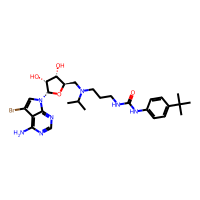
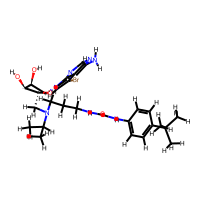
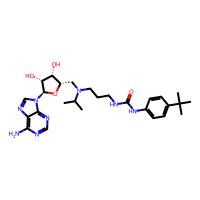
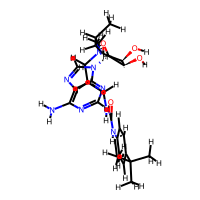
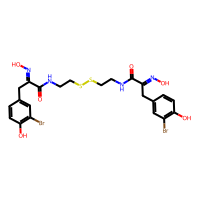
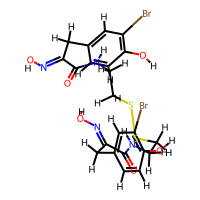
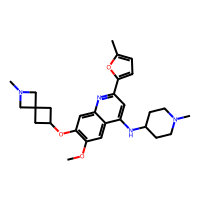
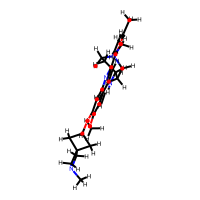
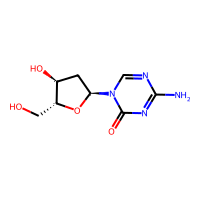
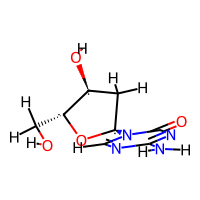
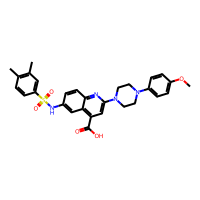
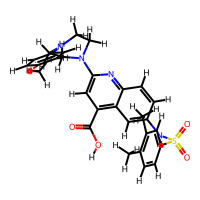
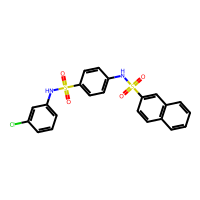
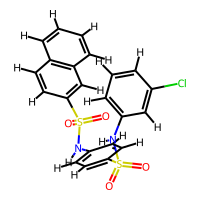
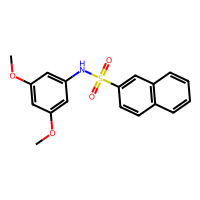
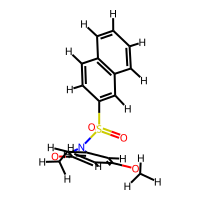
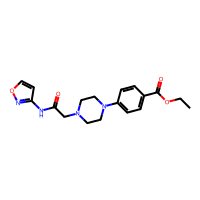
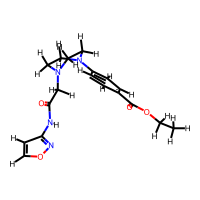
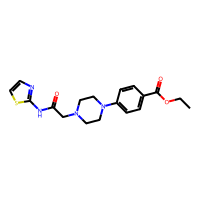
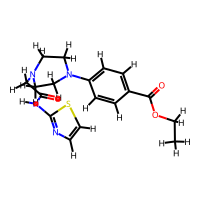

In [ ]:
fingerprint(dataframe=df)

<a name='4'></a>

# **4 - Referencias y fuentes de consulta**

* Gallegos Saliner A. 2006. “Mini-Review on Chemical Similarity and Prediction of Toxicity.” Current Computer-Aided Drug Design 2 (2): 105–22.
* Maggiora, Gerald, Martin Vogt, Dagmar Stumpfe, and Jürgen Bajorath. 2014. “Molecular Similarity in Medicinal Chemistry.” Journal of Medicinal Chemistry 57 (8): 3186–3204.
* Naveja, J. Jesús, Fernanda I. Saldívar-González, Norberto Sánchez-Cruz, and José L. Medina-Franco. 2019. “Cheminformatics Approaches to Study Drug Polypharmacology.” In Multi-Target Drug Design Using Chem-Bioinformatic Approaches, edited by Kunal Roy, 3–25. New York, NY: Springer New York.
* A.h.-L., and Y.g.s. 1992. “Concepts and Applications of Molecular Similarity.” Journal of Molecular Structure 269 (3-4): 376–77.
* Cereto-Massagué, Adrià, María José Ojeda, Cristina Valls, Miquel Mulero, Santiago Garcia-Vallvé, and Gerard Pujadas. 2015. “Molecular Fingerprint Similarity Search in Virtual Screening.” Methods 71 (January): 58–63.